## 模型选择

### 训练误差和泛化误差
- 训练误差：模型在**训练数据**上的误差
- 泛化误差：模型在**新数据**上的误差

### 验证数据集和测试数据集
- 验证数据集：用来**评估**模型好坏的数据集
- 测试数据集：**只用一次**的数据集（**不能**用来调超参数）
- 验证数据集一定不能和训练数据集混在一起

### K-则交叉验证
- 没有足够多数据时使用（这是常态）
- 算法：  
将训练数据分割为K块  
For i=1,...,K:使用第i块作为验证数据集，其余作为训练数据集  
报告K个验证集误差的平均  
常用：K=5或10

### 总结
- 训练数据集：训练模型参数
- 验证数据集：选择模型超参数
- 非大数据集上通常使用K-折交叉验证

## 过拟合和欠拟合

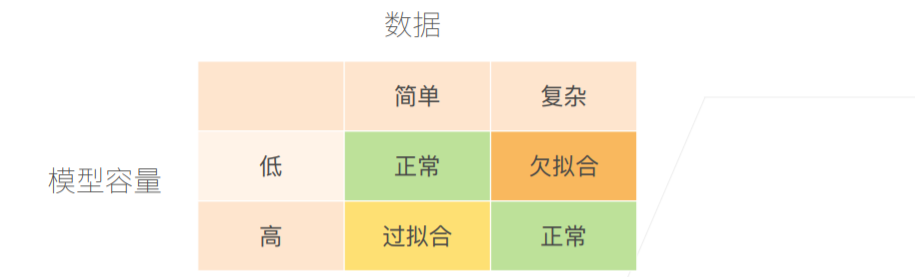
### 模型容量：  
- **拟合各种函数的能力**
- 低容量的模型**难以拟合**训练数据
- 高容量的模型可以**记住所有**的训练数据

### 模型容量的影响
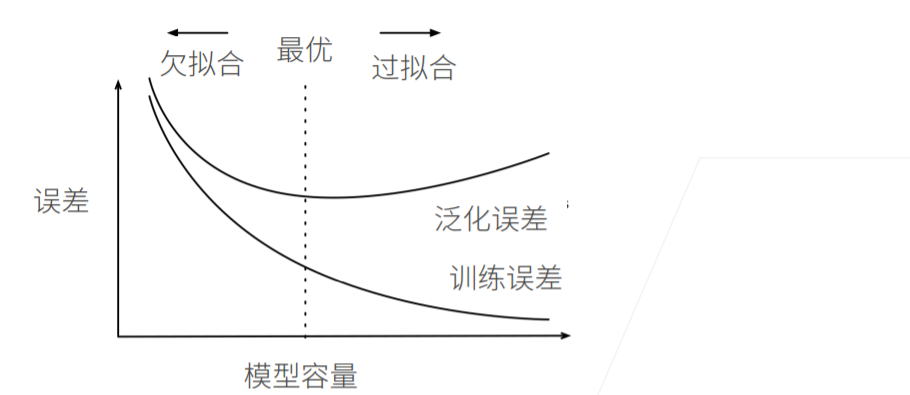
- **核心**：模型要先足够大，再通过各种手段控制模型容量，使得最终得到的泛化误差往下降

### 估计模型容量
- 难以在不同的种类算法之间比较  
如树模型和神经网络
- 给定一个模型种类，将有两个主要因素  
参数的个数  
参数值的选择范围

### VC维
- 统计学习理论的一个核心思想
- 对于一个**分类模型**，VC等于一个**最大的数据集的大小**，不管如何给定标号，都存在一个模型来对它进行完美分离

### 线性分类的VC维
- 2维输入的感知机，VC维=3  
能欧分类任何3个点，但不是4个（XOR）
-支持**N**维输入的感知机的VC维是**N+1**
- 一些**多层**感知机的VC维$O(N \log_2 N)$

### VC维的用处
- 提供为什么一个模型好的**理论依据 ** 
可以衡量**训练误差和泛化误差之间的间隔**
- 但在深度学习中很少使用：  
衡量不是很准确  
**计算深度学习模型的VC维很困难**

### 数据复杂度
多个重要因素
- 样本个数
- 每个样本的元素个数
- 时间、空间结构
- 多样性

### 总结
- 模型容量需要匹配数据复杂度，否则可能会导致欠拟合和过拟合
- 统计机器学习提供数学工具来衡量模型复杂度
- **实际中一般是靠观察训练误差和验证误差**

### **训练函数**

In [2]:
from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

## 简单演示过拟合和欠拟合现象

In [1]:
import torch
import numpy as np
import math

from torch import nn
from d2l import torch as d2l

### 生成数据集
使用一下三阶多项式来生成训练和测试数据的标签：
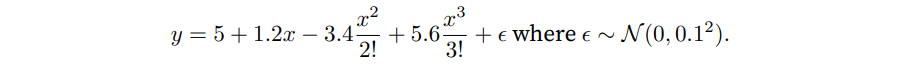
- 在优化过程中，通常希望**避免非常大的梯度值或损失值**，故将特征从$x^i$调整为$\frac{x^i}{i!}$的原因——比面很大的$i$带来的特别大的指数值
- `np.power(x1, x2)`：返回一个包含每个元素幂运算结果的数组，可有**广播机制**，**维数相同**
- `np.random.rand(d0, d1,..., dn)`：生成**标准正态分布**，参数是`size`  
`np.random.normal(loc= , scale= , size=())`：返回一个符合指定正态分布的随机数或数组
- `math.gamma(i)`有`gamma(n) = (n-1)!`

In [3]:
max_degree = 20                                         # 多项式的最大阶数
n_train, n_test = 100, 100            
true_w = np.zeros(max_degree)                           # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])             # 对应上面的三阶多项式

features = np.random.normal(size=(n_train + n_test, 1)) # 随机生成200个样本
np.random.shuffle(features)

# 生成多项式特征
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

# 计算标签并加入噪音
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)                        

将numpy转为**tensor**
- pytorch建议，如果已经有了一个`tensor`，且想要一个不带梯度的副本，可以使用`x.clone().detach()`

In [4]:
type(true_w), type(features), type(poly_features), type(labels)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [5]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) 
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2], labels[:2]

(tensor([[-0.1632],
         [ 1.5073]]),
 tensor([[ 1.0000e+00, -1.6318e-01,  1.3314e-02, -7.2423e-04,  2.9545e-05,
          -9.6426e-07,  2.6225e-08, -6.1136e-10,  1.2470e-11, -2.2611e-13,
           3.6897e-15, -5.4736e-17,  7.4433e-19, -9.3433e-21,  1.0890e-22,
          -1.1848e-24,  1.2083e-26, -1.1599e-28,  1.0515e-30, -9.0311e-33],
         [ 1.0000e+00,  1.5073e+00,  1.1360e+00,  5.7074e-01,  2.1507e-01,
           6.4833e-02,  1.6287e-02,  3.5070e-03,  6.6076e-04,  1.1066e-04,
           1.6680e-05,  2.2856e-06,  2.8709e-07,  3.3286e-08,  3.5837e-09,
           3.6011e-10,  3.3924e-11,  3.0079e-12,  2.5187e-13,  1.9981e-14]]),
 tensor([4.6426, 6.2053]))

### 对模型进行训练和测试
首先**实现一个函数来评估模型在给定数据集上的损失**

In [6]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

#### 定义**训练函数**，过程：
- 定义好**损失函数**
- 定义好`net`**神经网络**
- 准备好**数据迭代器**（指明`batch_size`大小）
- 定义好**优化方法**
- `train_epoch`  

`net[0].weight.data.numpy()`：获取权重参数 - 只获取纯数据部分 - 转numpy数组

In [7]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=1000):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1, 
                (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss))
            )
    print('weight', net[0].weight.data.numpy())  # 获取神经网络的第一个层的权重参数

### 三阶多项式函数拟合（正常）
先试用**三阶多项式**函数，是与数据生成函数的阶数相同
- 从多项式特征中选择前4个维度，即$1,x,x^2/2!,x^3/3!$

weight [[ 4.9900393  1.2204186 -3.3508112  5.532703 ]]


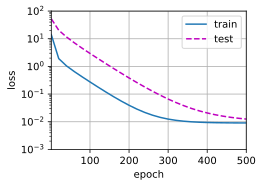

In [8]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
     labels[:n_train], labels[n_train:], num_epochs=500)

### 线性函数拟合（欠拟合）
若用**线性函数**拟合，减少该模型的训练损失相对困难，训练损失一直很高  
拟合非线性模型就容易**欠拟合**

weight [[3.7176368 2.7822309]]


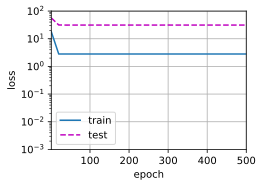

In [9]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:], num_epochs=500)

### 高阶多项式函数拟合（过拟合）
- 阶数过高，过于复杂的模型会轻易收到训练数据中*噪音*的影响  
- 训练数据可以有效的降低，但测试损失仍然很高，导致**过拟合**
- 选取多项式特征中所有维度

weight [[ 4.9742603   1.2607732  -3.238241    5.2527137  -0.5274812   1.1426213
   0.3362168   0.08324309  0.21321389 -0.21736932  0.00800725  0.18722002
   0.12947807 -0.25759453 -0.23820572]]


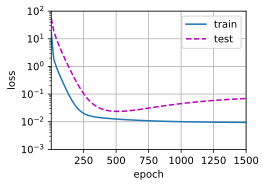

In [10]:
train(poly_features[:n_train, :15], poly_features[n_train:, :15],
     labels[:n_train], labels[n_train:], num_epochs=1500)

### 小结
- **欠拟合**是指模型**无法继续减少**训练误差
- **过拟合**是指训练误差**远小于**验证误差
- 由于不能基于训练误差来估计泛化误差，简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意**防止过拟合**，即防止泛化误差过大
- 验证集可以用于模型选择，但不能过于随意地使用
- 应该选择一个复杂度适当的模型，避免使用数量不足的训练样本

### 练习
1. 这个多项式回归问题可以准确地解出吗？提示：使用线性代数。
1. 考虑多项式的模型选择。
    1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
    1. 在这种情况下绘制测试的损失图。
    1. 生成同样的图，作为数据量的函数。
1. 如果不对多项式特征$x^i$进行标准化($1/i!$)，会发生什么事情？能用其他方法解决这个问题吗？
1. 泛化误差可能为零吗

### 回答
1. 可以通过线性代数中的**最小二乘法**准确求解——使用矩阵求解方法，找到哦啊最小化训练误差的多项式系数
2. 

### 实验
评估不同多项式阶数的模型在训练集和测试集上的损失并绘制其变化
- 没有使用`train`函数，而是使用`train_epoch_ch3`
- 通过`evaluate_loss`计算损失

([24.140804862976076,
  8.65767442703247,
  4.8797712326049805,
  0.012189362123608589,
  0.012641410492360592,
  0.018871709927916525,
  0.018860029578208922,
  0.015856666415929796,
  0.018185508474707603,
  0.01668910004198551,
  0.017697822153568268,
  0.016963914930820466,
  0.01721905954182148,
  0.016419144943356515,
  0.017113819792866705,
  0.017659080773591997,
  0.01803907983005047,
  0.016736516356468202,
  0.017005635760724544,
  0.018101120293140413],
 [13.69311321258545,
  5.1708698654174805,
  2.9878623485565186,
  0.01103134721517563,
  0.010957022979855537,
  0.01208882175385952,
  0.012192397788167,
  0.01065600223839283,
  0.011709067225456237,
  0.01100056130439043,
  0.01147632285952568,
  0.011121941991150379,
  0.011302756145596504,
  0.010947545878589154,
  0.011246268190443515,
  0.011537770591676235,
  0.011631800457835198,
  0.01098626259714365,
  0.011159776709973812,
  0.011685227006673814])

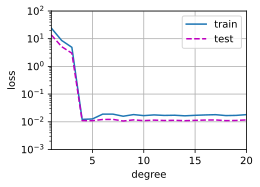

In [28]:
n_train, n_test = 100, 100

def train4_4_2(orderlist, n_train, n_test, num_epochs=500, show=True):
    max_degree = 20
    true_w = np.zeros(max_degree)
    true_w[:4] = np.array([5, 1.2, -3.4, 5.6])

    features = np.random.normal(size=(n_train + n_test, 1))
    np.random.shuffle(features)
    poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
    for i in range(max_degree):
        poly_features[:, i] /= math.gamma(i + 1)

    labels = np.dot(poly_features, true_w)
    labels += np.random.normal(scale=0.1, size=labels.shape)

    true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

    if show == True:
        animator = Animator(xlabel='degree', ylabel='loss', yscale='log',
                            xlim=[1, orderlist[-1]], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    train_loss_list, test_loss_list = [], []
    for i in orderlist:
        train_features, test_features, train_labels, test_labels = poly_features[:n_train, :i],poly_features[n_test:, :i],labels[:n_train], labels[n_test:]
        
        loss = nn.MSELoss(reduction='none')
        
        input_shape = train_features.shape[-1]
        net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
        
        batch_size = min(10, train_labels.shape[0])
        train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
        test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size)
        
        trainer = torch.optim.SGD(net.parameters(), lr=0.01)

        for epoch in range(num_epochs):
            train_epoch_ch3(net, train_iter, loss, trainer)
        train_loss = evaluate_loss(net, train_iter, loss)
        test_loss = evaluate_loss(net, test_iter, loss)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

        if show == True:
            animator.add(i, (train_loss, test_loss))

    return train_loss_list, test_loss_list

train4_4_2(np.arange(1, 21), n_train, n_test)

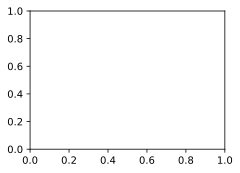

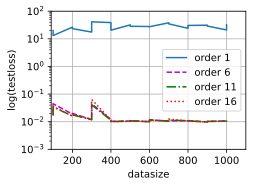

In [30]:
animator = Animator(xlabel='datasize', ylabel='log(trainloss)', yscale='log',
                                xlim=[90, 1100], ylim=[1e-3, 1e2],
                                legend=list(map(lambda x: "order {}".format(x), np.arange(1,21,5))))
animator = Animator(xlabel='datasize', ylabel='log(testloss)', yscale='log',
                                xlim=[90, 1100], ylim=[1e-3, 1e2],
                                legend=list(map(lambda x: "order {}".format(x), np.arange(1,21,5))))
for datasize in range(100, 1100, 100):
    train_loss_list, test_loss_list = train4_4_2(np.arange(1, 21, 5),datasize, datasize,num_epochs=400,show=False)
    animator.add(datasize, list(train_loss_list))
    animator.add(datasize, list(test_loss_list))

### Q&A
1. SVM主要的缺点：若是Kernal SVM的话，很难做到100万个数据点，数据点少挺好的，一大就很难了；可调性不强（数学解释很好，但是可编程性差）

2. 神经网络的优点：本身是一种语言，编程性很好；通过卷积做比较好的特征提取
3. **HPO(Hyperparameter Optimization)** ，调整超参数，推荐使用**随机方法**，还有贝叶斯方法、网格等
4. 假如对一个二分类，两类数量严重不平衡
- 如果数据足够多就无所谓
- 否则验证集的两种类型比例要差不多，或者给权重（在loss里）什么的
5. k折交叉验证就是为了确定超参数，确定好超参数组合后
- 在整个数据集上重新训练一次模型，以充分利用所有的数据
- 不再重新训练，就把k折交叉验证中选定好的超参数拿出来，选一个性能最好的模型，仍然可以获得一个相对好的模型
- **集成学习**的一种形式，保留k折交叉验证的k个模型，预测时，把测试数据集全部都预测取平均
6. **随机森林**：通过**集成多个决策树**来降低单棵树的过拟合问题，并提高模型的泛化能力，通过引入随机性来确保每棵决策树相互独立、互补错误，从而提高整体模型的性能
- 样本随机性，**bootstrap**
- 特征随机性

7. 无限VC维：模型的VC维非常大，甚至可以无限制增长，意味着模型具有极高的**复杂度**和**表达能力**，但也意味着容易过拟合，泛化能力差
- 正则化、早停、交叉验证